# Named Entity Recognition (NER)

#### Task 1: Import Modules

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

np.random.seed(0)
plt.style.use("ggplot")
tf.random.set_seed(42)

%matplotlib inline

2023-10-12 18:47:50.806460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.14.0
GPU detected: []


#### Task 2: Load and Explore dataset

In [3]:
# import data
df = pd.read_csv('./data/ner_dataset.csv', encoding='unicode_escape')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
# check for null values
df.isna().sum()

Sentence #    1000616
Word               10
POS                 0
Tag                 0
dtype: int64

In [5]:
# replace null values
df.fillna(method='ffill', inplace=True)

/var/folders/f4/qhd7051s45b5vn6kwkjfrhr40000gn/T/ipykernel_99609/2353788911.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [6]:
# check for null values again
df.isna().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [7]:
# print number of unique words and tags
df[['Word', 'Tag']].nunique()

Word    35177
Tag        17
dtype: int64

In [8]:
# get unique words
unique_words = list(set(df['Word'].values))
_PAD = '__PAD__'
unique_words.append(_PAD) # used for padding
num_unique_words = len(unique_words)

In [9]:
# get unique tags
unique_tags = list(set(df['Tag'].values))
num_unique_tags = len(unique_tags)

In [10]:
# print number of unique words and tags
num_unique_words, num_unique_tags

(35178, 17)

In [11]:
# group word, pos, tag by sentence #
df_group = df.groupby("Sentence #").apply(lambda s:[(w, p, t) for w, p, t in zip(s['Word'].tolist(), s['POS'].tolist(), s['Tag'].tolist())])

In [12]:
df_sentences = df_group.reset_index().rename(columns={0: 'w,p,t'})
df_sentences.head()

,Sentence #,"w,p,t"
0,Sentence: 1,"[(Thousands, NNS, O), (of, IN, O), (demonstrat..."
1,Sentence: 10,"[(Iranian, JJ, B-gpe), (officials, NNS, O), (s..."
2,Sentence: 100,"[(Helicopter, NN, O), (gunships, NNS, O), (Sat..."
3,Sentence: 1000,"[(They, PRP, O), (left, VBD, O), (after, IN, O..."
4,Sentence: 10000,"[(U.N., NNP, B-geo), (relief, NN, O), (coordin..."


#### Task 3: Generate Word:Index and Tag:Index dictionaries

In [13]:
# generate index dictionaries
word2idx =  {w : i for i, w in enumerate(unique_words)}
tag2idx  =  {t : i for i, t in enumerate(unique_tags)}

In [14]:
# print word2idx
pd.DataFrame([word2idx]).transpose().reset_index().rename(columns={'index': 'Word', 0: 'Index'}).head(10)

,Word,Index
0,quarter-century,0
1,third-holiest,1
2,Yoshinori,2
3,Tamara,3
4,congregate,4
5,downward,5
6,pre-Olympic,6
7,Peretz,7
8,8956-kilometer,8
9,administrators,9


In [15]:
# print tag2idx
pd.DataFrame([tag2idx]).transpose().reset_index().rename(columns={'index': 'Tag', 0: 'Index'}).head(10)

,Tag,Index
0,I-eve,0
1,B-org,1
2,B-nat,2
3,I-per,3
4,B-geo,4
5,B-tim,5
6,O,6
7,B-art,7
8,B-gpe,8
9,I-art,9


#### Task 5: Pad input sequences and create train/test split

In [16]:
# compute max sentence length
max_sentence_len = max([len(sentence) for sentence in df_sentences['w,p,t'].values])
max_sentence_len

104

In [17]:
# pad X sequences
X = [[word2idx[wpt[0]] for wpt in sentence] for sentence in df_sentences['w,p,t'].values]
X = pad_sequences(sequences=X, maxlen=max_sentence_len, padding='post', value=num_unique_words-1)
len(X)

47959

In [18]:
# pad y sequences
y = [[tag2idx[wpt[2]] for wpt in sentence]for sentence in df_sentences['w,p,t'].values]
y = pad_sequences(sequences=y, maxlen=max_sentence_len, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_unique_tags) for i in y]
len(y)

47959

In [19]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Task 6: Build and Compile a Bidirectional LSTM Model

In [20]:
# build the model
input_word = Input(shape = (max_sentence_len,))
model = Embedding(input_dim=num_unique_words, output_dim=max_sentence_len, input_length=max_sentence_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_unique_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding (Embedding)       (None, 104, 104)          3658512   
                                                                 
 spatial_dropout1d (Spatial  (None, 104, 104)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 104, 200)          164000    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 104, 17)           3417      
 ributed)                                                        
                                                             

In [21]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Task 7: Train the model

In [22]:
# initialize early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

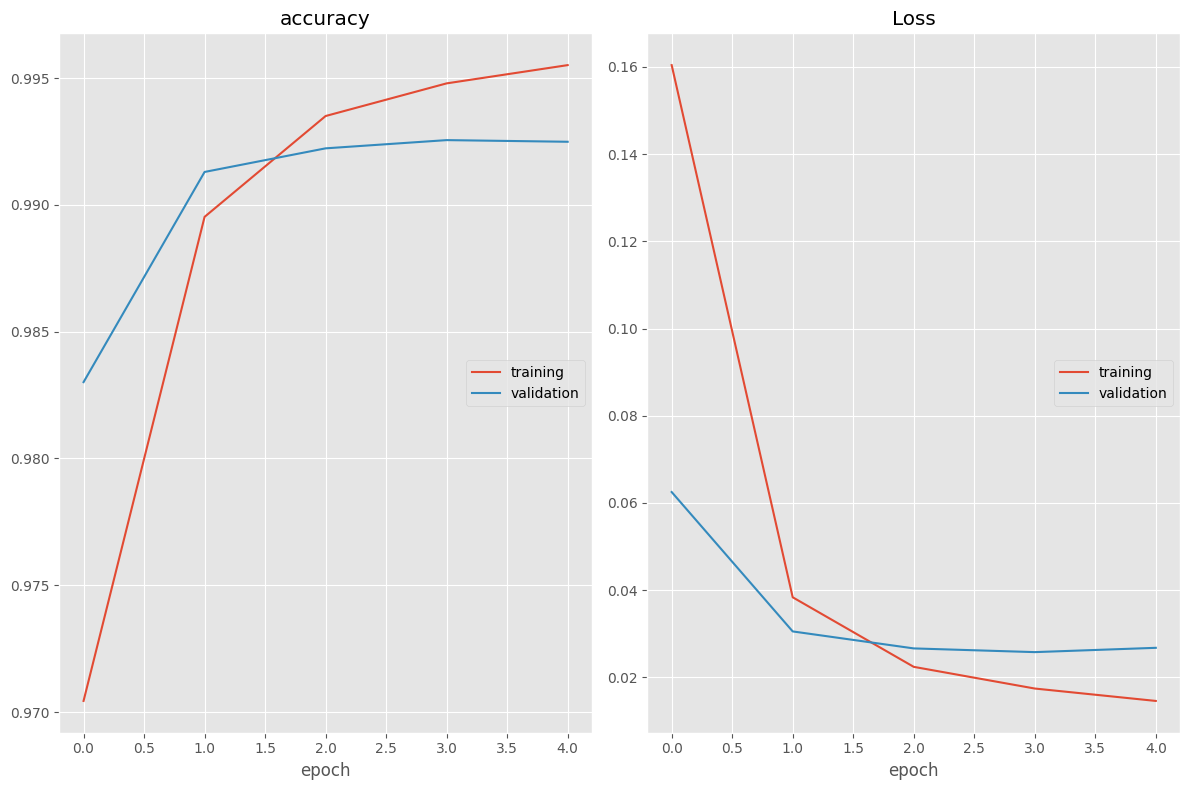

accuracy
	training         	 (min:    0.970, max:    0.996, cur:    0.996)
	validation       	 (min:    0.983, max:    0.993, cur:    0.992)
Loss
	training         	 (min:    0.015, max:    0.160, cur:    0.015)
	validation       	 (min:    0.026, max:    0.062, cur:    0.027)
480/480 [==============================] - 237s 494ms/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 0.0268 - val_accuracy: 0.9925


In [24]:
# fit the model
history = model.fit(
    X_train,
    np.array(y_train),
    validation_split=0.2,
    batch_size=64,
    epochs=5,
    verbose=1,
    callbacks=callbacks
)

#### Task 8: Evaluate the model

In [31]:
# generate random number
rand_num = np.random.randint(0, X_test.shape[0])
rand_num

3264

In [32]:
# make the prediction
y_pred_arr = model.predict(np.array([X_test[rand_num]]))
y_pred = np.argmax(y_pred_arr, axis=-1)

# get the ground truth
y_true = np.argmax(np.array(y_test), axis=-1)[rand_num]

1/1 [==============================] - 0s 35ms/step


In [33]:
# prepare results
results = []
for idx, true, pred in zip(X_test[rand_num], y_true, y_pred[0]):
  results.append([idx, unique_words[idx], unique_tags[true], unique_tags[pred]])

In [34]:
# display results
pd.set_option('display.max_rows', None)
df_results = pd.DataFrame(results, columns=['Index', 'Word', 'y_true', 'y_pred'])
df_results.drop(df_results[df_results.Word == _PAD].index, inplace=True)
df_results

,Index,Word,y_true,y_pred
0,29547,The,O,O
1,28551,lion,O,O
2,14167,dance,O,O
3,8770,is,O,O
4,12698,one,O,O
5,29365,of,O,O
6,3526,China,B-geo,B-geo
7,20558,'s,O,O
8,21436,most,O,O
9,13853,distinctive,O,O
